# in this phyloseq I am using the cutadapt product where:
- primers were not anchored, and discard_untrimmed was used
## this led to higher numbers of reads in dada2

# including Conditions and health status 
- visualize the effect of bleaching

In [2]:
require(data.table)
require(tidyverse)
require(dplyr)
require(phyloseq)
require(genefilter)
require(ggplot2)
require(RColorBrewer)
require(metacoder)
require(vegan)
require(DESeq2)
options(repr.plot.width=20, repr.plot.height=15)

In [3]:
#load sample metadata skipping first row
#load tracker for reads
track=fread("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/ASVs/Seqnums_16S.csv")
#load sample metadata
samdt=fread("/home/caroline_desouza_uml_edu/2_randomized_immune_metagenomics_PCR.csv", header=TRUE)
condition=fread("/home/caroline_desouza_uml_edu/pcr_meta.csv", header=TRUE)
#load csv files after removing chimeras
asv_all=fread("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/ASVs/16S_ASV_nochim.csv")
taxa=read.csv(file="/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/ASVs/16S_taxa.csv", header=TRUE, row.names=1)

In [7]:
condition <- condition[, c("V1", "MonthYear", "colony", "Health_Status", "Date_ITS2") := NULL]

Warning message in `[.data.table`(condition, , `:=`(c("V1", "MonthYear", "colony", :
“Column 'V1' does not exist to remove”
Warning message in `[.data.table`(condition, , `:=`(c("V1", "MonthYear", "colony", :
“Column 'colony' does not exist to remove”
Warning message in `[.data.table`(condition, , `:=`(c("V1", "MonthYear", "colony", :
“Column 'Health_Status' does not exist to remove”
Warning message in `[.data.table`(condition, , `:=`(c("V1", "MonthYear", "colony", :
“Column 'Date_ITS2' does not exist to remove”


In [9]:
#add conditions from pcr=read.csv(file="/home/caroline_desouza_uml_edu/pcr_meta.csv", header=TRUE, row.names=1)
samdt <- merge(samdt, condition, by = "Tubelabel_species", all = FALSE)

In [10]:
head(condition)
head(samdt)

Tubelabel_species,Condition
<chr>,<chr>
052022_BEL_CBC_T1_2_SSID,Diseased
052022_BEL_CBC_T2_9_PAST,Healthy
052022_BEL_CBC_T2_1_SSID,Healthy
052022_BEL_CBC_T2_71_OFAV,Healthy
052022_BEL_CBC_T3_8_PAST,Healthy
052022_BEL_CBC_T3_13_MCAV,Healthy


Tubelabel_species,V1,Health_Status,Date_Extracted,Raw_ng_ul,Extraction_physical_location,Date_Enriched,Microbe_Location,colony,Date_16S,Date_ITS2,16S double band,Condition
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
012024_BEL_CBC_T1_557_SSID,50,Healthy,2_17_2025,44.6,UML_NARWHAL_R2_B16,,,1_3,3_4_2025,7_7_2025,y,Healthy
012024_BEL_CBC_T1_563_PSTR,58,Healthy,2_17_2025,35.8,UML_NARWHAL_R2_B16,,,1_12,3_6_2025,7_7_2025,,Healthy
012024_BEL_CBC_T2_601_OFAV,48,Healthy,2_17_2025,89,UML_NARWHAL_R2_B16,,,2_79,3_4_2025,7_7_2025,,Healthy
012024_BEL_CBC_T2_605_SSID,89,Healthy,2_17_2025,59.8,UML_NARWHAL_R2_B16,,,2_99,3_10_2025,7_10_2025,y,CLB
012024_BEL_CBC_T3_627_PAST,81,Healthy,2_20_2025,10.5,UML_NARWHAL_R2_B16,,,3_34,3_10_2025,7_10_2025,y,Healthy
012024_BEL_CBC_T3_631_MCAV,49,Healthy,2_20_2025,77.6,UML_NARWHAL_R2_B16,,,3_21,3_4_2025,7_7_2025,,Healthy


In [11]:
class(samdt)
class(condition)

[1] "data.table" "data.frame"

[1] "data.table" "data.frame"

### organize sample data

In [12]:
#cleaning samdt 
samdt <- samdt[samdt$Date_16S != 'NA', ]
# Create a new data frame with the species, date, and transect columns
# Example samdt (make sure your data is a data.table)
setDT(samdt)
# Split Tubelabel_species by "_" and assign new columns
samdt[, c("date_sampled", "transect", "species") := {
  parts <- strsplit(Tubelabel_species, "_")
  list(
    sapply(parts, `[`, 1),  # date is first element
    sapply(parts, `[`, 4),  # transect is 4th element
    sapply(parts, `[`, 6)   # species is 6th element
  )
}]

In [15]:
# Rename double band
sample_16Sdoubl <- setnames(samdt, "16S double band", "double_band", skip_absent=TRUE)
# Rename a date to date sampled
sample_date <- setnames(sample_16Sdoubl, "date", "date_sampled", skip_absent=TRUE)
#changing format of date_sampled to be Jan 2024
sample_date$date_sampled <- as.factor(sample_date$date_sampled)
# Convert to Date format 
sample_date$DateFormatted <- as.Date(paste0(sample_date$date_sampled, "01"), format = "%m%Y%d")
# now will have a new column that has Month Year instead of date_sampled
sample_date$MonthYear <- format(sample_date$DateFormatted, "%b %Y")
sample_date$MonthYear <- factor(sample_date$MonthYear, levels = unique(sample_date$MonthYear))

#MonthYear in chronological order

In [17]:
head(sample_date)

Tubelabel_species,V1,Health_Status,Date_Extracted,Raw_ng_ul,Extraction_physical_location,Date_Enriched,Microbe_Location,colony,Date_16S,Date_ITS2,double_band,Condition,date_sampled,transect,species,DateFormatted,MonthYear
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<date>,<fct>
012024_BEL_CBC_T1_557_SSID,50,Healthy,2_17_2025,44.6,UML_NARWHAL_R2_B16,,,1_3,3_4_2025,7_7_2025,y,Healthy,012024,T1,SSID,2024-01-01,Jan 2024
012024_BEL_CBC_T1_563_PSTR,58,Healthy,2_17_2025,35.8,UML_NARWHAL_R2_B16,,,1_12,3_6_2025,7_7_2025,,Healthy,012024,T1,PSTR,2024-01-01,Jan 2024
012024_BEL_CBC_T2_601_OFAV,48,Healthy,2_17_2025,89,UML_NARWHAL_R2_B16,,,2_79,3_4_2025,7_7_2025,,Healthy,012024,T2,OFAV,2024-01-01,Jan 2024
012024_BEL_CBC_T2_605_SSID,89,Healthy,2_17_2025,59.8,UML_NARWHAL_R2_B16,,,2_99,3_10_2025,7_10_2025,y,CLB,012024,T2,SSID,2024-01-01,Jan 2024
012024_BEL_CBC_T3_627_PAST,81,Healthy,2_20_2025,10.5,UML_NARWHAL_R2_B16,,,3_34,3_10_2025,7_10_2025,y,Healthy,012024,T3,PAST,2024-01-01,Jan 2024
012024_BEL_CBC_T3_631_MCAV,49,Healthy,2_20_2025,77.6,UML_NARWHAL_R2_B16,,,3_21,3_4_2025,7_7_2025,,Healthy,012024,T3,MCAV,2024-01-01,Jan 2024


In [19]:
 #cleaning up sample_norm to only be metadata
samdt<- sample_date[, c("Tubelabel_species", "Health_Status", "colony", "Date_16S", "double_band", "transect", "species", "MonthYear", "Condition")]
head(samdt)

Tubelabel_species,Health_Status,colony,Date_16S,double_band,transect,species,MonthYear,Condition
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>
012024_BEL_CBC_T1_557_SSID,Healthy,1_3,3_4_2025,y,T1,SSID,Jan 2024,Healthy
012024_BEL_CBC_T1_563_PSTR,Healthy,1_12,3_6_2025,,T1,PSTR,Jan 2024,Healthy
012024_BEL_CBC_T2_601_OFAV,Healthy,2_79,3_4_2025,,T2,OFAV,Jan 2024,Healthy
012024_BEL_CBC_T2_605_SSID,Healthy,2_99,3_10_2025,y,T2,SSID,Jan 2024,CLB
012024_BEL_CBC_T3_627_PAST,Healthy,3_34,3_10_2025,y,T3,PAST,Jan 2024,Healthy
012024_BEL_CBC_T3_631_MCAV,Healthy,3_21,3_4_2025,,T3,MCAV,Jan 2024,Healthy


## filtering samples with less than 10K reads

In [20]:
#cleaning track of samples with less than 10K reads
clean_track <- track[track$nonchim > 10000, ]
setnames(clean_track, c("V1"), c("Tubelabel_species"), skip_absent=TRUE)
head(clean_track)

Tubelabel_species,input,filtered,denoisedF,denoisedR,merged,nonchim
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
012024-BEL-CBC-T1-557-SSID,140907,132539,130818,130771,127036,118800
012024-BEL-CBC-T1-563-PSTR,97665,89798,89392,89308,88670,48116
012024-BEL-CBC-T2-601-OFAV,263467,250569,249704,249707,248016,191585
012024-BEL-CBC-T2-605-SSID,605361,574264,571735,571551,564520,517961
012024-BEL-CBC-T3-627-PAST,1656969,1561240,1540358,1539923,1487115,1323604
012024-BEL-CBC-T3-631-MCAV,513353,484960,483847,483931,476841,424109


In [23]:
#compare track to clean
anti_join(track, clean_track, by = NULL, copy = FALSE)

Joining with `by = join_by(input, filtered, denoisedF, denoisedR, merged,
nonchim)`


V1,input,filtered,denoisedF,denoisedR,merged,nonchim
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
042024-BEL-CBC-T3-960-OFAV,20490,19399,18468,18916,17869,3853
122022-BEL-CBC-T3-142-MCAV,7052,6583,6291,6279,6067,4868
Negative,1768,1604,1352,1322,971,940


### the above samples got filtered out

## joining asv_all and clean track

In [24]:
#reconfigure names in asv_all
setDT(asv_all, keep.rownames = "Tubelabel_species")[]
setnames(asv_all, c("V1"), c("Tubelabel_species"), skip_absent=TRUE)

V1,GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGG,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,GCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGG,GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGCTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGG,GCAAGCGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAGTGTGTTCTTAGTTAAATTATGAAGCCTAACTTCATGAAAAGTAAGAAAACTATTAGACTTGAGTACGATAGGGGTAAGAGGAATTCTTCGAGAAGTAGTGAAATGCGAAGATACGAAGGAGAAGATCATAAGCGAAGGCTTCTTACTGGGTCGTAACTGACACTGAGAGACGAAAGCTAGGGG,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,GCAAGCGTTATTCGGAATTATTGGGCGTAAAGGGTCTGTAGGTGGTTTTTTAAGTCTACTGTTAAATCTTAAGGCTTAACCTTAAAAAAGCGGTATGAAACTGAAAAGCTTGAGTTTAGTAGGGGTAGAGGGAATTCTCGGTGTAGTGGTGAAATGCGTAGAGATCGAGAAGAACACCGGTAGCGAAGGCGCTCTGCTGGGCTAAAACTGACACTGAGAGACGAAAGCTAGGGG,TCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTTGCTAAGTCAGATGTGAAATCCCTGGGCTTAACCTAGGAACTGCATTTGAAACTAGCAAGCTAGAGTATGGTAGAGGTGGGTGGAATTTCAGGTGTAGCGGTGGAATGCGTAGAGATCTGAAGGAACATCAGTGGCGAAGGCGGCTCACTGGGCCATCACTGACGCTGAGGTGCGAAAGCGTGGGT,⋯,GGCTCTGTAAGTGGTGTGTGAAAGCCCCTGGCTCAACCAGGGAATTGCGCTCCAAACTACAGAGCTTGAGGGCAGTAGAGGAAACTGGAATTCCTGGTGTAGCGGTGAAATGCGTAGATATCAGGAGGAACATCATTGGCGAAGGCGAGTTTCTGGGCTGTCCCTGACGCTGATGCGCGAAAGCTGGGGGAGCAAACAGGATTAGAAACCCGTGTAG,GGTGCGGTAAGTGAGGTGTGAAATCCCCCGGCTCAACCGAGGAATTGCGCTTCATACTGCCGTGCTAGAGGGAGACAGAGGTAAGCGGAACTGATGGTGGAGCGGTGAAATGCGTTGATATCATCAGGAACACCGGTGGCGAAAGCGGCTTACTGGGTCTCTTCTGACGCTGAGGCACGAAAGCTAGGGTAGCGAACGGGATTAGATACCCGGGTAGTCC,GCAAGCGTTATTCGGAATTATTGGGCGTAAAGGGTCTGTAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATCCTGACACTCAGATGCGACAGCGTGGGG,GGTGAGTCAAGTTACCTATGAAAGATACAGGCTAAACTTGTATTGGTTAGGTGAAACTGTCTGACTAGAGAGAAATAGAGGGAAGTAGAATTCCGGGTGTAGTGGTGAAATGCGTAGATATCCGGAGGAATATCGGTGGCGAAGGCGGCTTCCTGGATTTCGACTGACGCTGATGCGCGAAAGCGTGGGTAGCGAACGGGATTAGATACCCGAGTAGTCCCGACTGTCTCTTATACACATCTCCGA,CAGCCGCGGTAATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAATAGCGAAAGCACTCTACTAGG,CAGCCGCGGTAATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCGATGGCGAAGGCAGCCATCTGGC,CAGCCGCGGTAATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCGGAGGCGAAGGCGACTCACTGGT,TTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGGCGTGCAGGCGGACCGATAAGTCGTCTGTGAAATCTGTCGGCTCAACCAACAACTTGCAGTCGAAACTATCGGTCTTGAGTACAGGAGAGGAGAGCGGAATCTCAGGTGTAGCGGTGAAATGCGTAGATATCTGGGAGAACACCGGTGGCGAAGGCGGCTCTCTGGAAGGATACTGACGCTGAGGCGCGAAAGCTAGGGG,ACTTTTTAAGTCTACTGTTAAAGAATAAGACTTAACCTTAAAAAAGCGGTATGAAACTGAAAA

In [25]:
#great now inner join to format asv_all based on clean_track
# Ensure both are data.tables
setDT(asv_all)
setDT(clean_track)
asv_clean <- merge(asv_all, clean_track, by = "Tubelabel_species", all = FALSE)

In [26]:
#check to make sure clean_track matches asv_clean
nrow(asv_all)
nrow(asv_clean)
nrow(clean_track)

[1] 97

[1] 94

[1] 94

In [27]:
# Step 1: Replace '-' with '_' in asv_clean$Tube
asv_clean$Tubelabel_species <- gsub("-", "_", asv_clean$Tubelabel_species)
head(asv_clean)

Tubelabel_species,GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGG,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,GCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGG,GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGCTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGG,GCAAGCGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAGTGTGTTCTTAGTTAAATTATGAAGCCTAACTTCATGAAAAGTAAGAAAACTATTAGACTTGAGTACGATAGGGGTAAGAGGAATTCTTCGAGAAGTAGTGAAATGCGAAGATACGAAGGAGAAGATCATAAGCGAAGGCTTCTTACTGGGTCGTAACTGACACTGAGAGACGAAAGCTAGGGG,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,GCAAGCGTTATTCGGAATTATTGGGCGTAAAGGGTCTGTAGGTGGTTTTTTAAGTCTACTGTTAAATCTTAAGGCTTAACCTTAAAAAAGCGGTATGAAACTGAAAAGCTTGAGTTTAGTAGGGGTAGAGGGAATTCTCGGTGTAGTGGTGAAATGCGTAGAGATCGAGAAGAACACCGGTAGCGAAGGCGCTCTGCTGGGCTAAAACTGACACTGAGAGACGAAAGCTAGGGG,TCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTTGCTAAGTCAGATGTGAAATCCCTGGGCTTAACCTAGGAACTGCATTTGAAACTAGCAAGCTAGAGTATGGTAGAGGTGGGTGGAATTTCAGGTGTAGCGGTGGAATGCGTAGAGATCTGAAGGAACATCAGTGGCGAAGGCGGCTCACTGGGCCATCACTGACGCTGAGGTGCGAAAGCGTGGGT,⋯,CAGCCGCGGTAATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCGGAGGCGAAGGCGACTCACTGGT,TTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGGCGTGCAGGCGGACCGATAAGTCGTCTGTGAAATCTGTCGGCTCAACCAACAACTTGCAGTCGAAACTATCGGTCTTGAGTACAGGAGAGGAGAGCGGAATCTCAGGTGTAGCGGTGAAATGCGTAGATATCTGGGAGAACACCGGTGGCGAAGGCGGCTCTCTGGAAGGATACTGACGCTGAGGCGCGAAAGCTAGGGG,ACTTTTTAAGTCTACTGTTAAAGAATAAGACTTAACCTTAAAAAAGCGGTATGAAACTGAAAAGCTTGAGTTTAGTAGGGGTAGAGGGAATTCTCGGTGTAGTGGTGAAATGCGTAGAGATCGAGAAGAACACCGGTAGCGAAGGCGCTCTGCTGGGCTAAAACTGACACTGAGAGACGAAAGCTAGGGGAGCAAATAGGATTAGAAACCCTAGTAGTCCGACTGTCTCTT,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGCTAGATGTGAAAGCCCCGGGCTCAACCTGGGATGGTCATTTAGAACTGGCAGACTAGAGTCTTGGAGAGGGGAGTGGAATTCCAGGTGTAGCGGTGAAATGCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCGACTCCCTGGAAAAAGACTGACGCTCATGTGCGAAAGTGTGGGT,input,filtered,denoisedF,denoisedR,merged,nonchim
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
012024_BEL_CBC_T1_557_SSID,43,578,4752,32,0,420,62,5729,12,⋯,0,0,0,0,140907,132539,130818,130771,127036,118800
012024_BEL_CBC_T1_563_PSTR,0,151,38,55,8,1360,0,9150,0,⋯,0,0,0,0,97665,89798,89392,89308,88670,48116
012024_BEL_CBC_T2_601_OFAV,7,277,2343,5314,0,6594,120,41,10766,⋯,0,0,0,0,263467,250569,249704,249707,248016,191585
012024_BEL_CBC_T2_605_SSID,38,434,15112,12,0,15645,149,42725,14,⋯,0,0,0,0,605361,574264,571735,571551,564520,517961
012024_BEL_CBC_T3_627_PAST,0,872,49,88,0,2126,0,22671,25,⋯,0,0,0,0,1656969,1561240,1540358,1539923,1487115,1323604
012024_BEL_CBC_T3_631_MCAV,45,331,120,6,0,175799,0,5048,11,⋯,0,0,0,0,513353,484960,483847,483931,476841,424109


## now filtering samdt based on clean_track

In [28]:
#exclude samples that are not in asv_clean
samdf <- merge(samdt, asv_clean, by = "Tubelabel_species", all = FALSE)

In [29]:
class(asv_clean)
class(samdf)
class(taxa)

[1] "data.table" "data.frame"

[1] "data.table" "data.frame"

[1] "data.frame"

## prepping for phyloseq

In [30]:
#fix asv_all rownames
rows=as.vector(asv_clean[,1])
asv_clean=asv_clean[,-1]
asv_clean=apply(asv_clean, 2, as.numeric)
row.names(asv_clean)=rows$Tubelabel_species
head(asv_clean)

,GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGG,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,GCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGG,GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGCTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGG,GCAAGCGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAGTGTGTTCTTAGTTAAATTATGAAGCCTAACTTCATGAAAAGTAAGAAAACTATTAGACTTGAGTACGATAGGGGTAAGAGGAATTCTTCGAGAAGTAGTGAAATGCGAAGATACGAAGGAGAAGATCATAAGCGAAGGCTTCTTACTGGGTCGTAACTGACACTGAGAGACGAAAGCTAGGGG,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,GCAAGCGTTATTCGGAATTATTGGGCGTAAAGGGTCTGTAGGTGGTTTTTTAAGTCTACTGTTAAATCTTAAGGCTTAACCTTAAAAAAGCGGTATGAAACTGAAAAGCTTGAGTTTAGTAGGGGTAGAGGGAATTCTCGGTGTAGTGGTGAAATGCGTAGAGATCGAGAAGAACACCGGTAGCGAAGGCGCTCTGCTGGGCTAAAACTGACACTGAGAGACGAAAGCTAGGGG,TCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTTGCTAAGTCAGATGTGAAATCCCTGGGCTTAACCTAGGAACTGCATTTGAAACTAGCAAGCTAGAGTATGGTAGAGGTGGGTGGAATTTCAGGTGTAGCGGTGGAATGCGTAGAGATCTGAAGGAACATCAGTGGCGAAGGCGGCTCACTGGGCCATCACTGACGCTGAGGTGCGAAAGCGTGGGT,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATTGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,⋯,CAGCCGCGGTAATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCGGAGGCGAAGGCGACTCACTGGT,TTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGGCGTGCAGGCGGACCGATAAGTCGTCTGTGAAATCTGTCGGCTCAACCAACAACTTGCAGTCGAAACTATCGGTCTTGAGTACAGGAGAGGAGAGCGGAATCTCAGGTGTAGCGGTGAAATGCGTAGATATCTGGGAGAACACCGGTGGCGAAGGCGGCTCTCTGGAAGGATACTGACGCTGAGGCGCGAAAGCTAGGGG,ACTTTTTAAGTCTACTGTTAAAGAATAAGACTTAACCTTAAAAAAGCGGTATGAAACTGAAAAGCTTGAGTTTAGTAGGGGTAGAGGGAATTCTCGGTGTAGTGGTGAAATGCGTAGAGATCGAGAAGAACACCGGTAGCGAAGGCGCTCTGCTGGGCTAAAACTGACACTGAGAGACGAAAGCTAGGGGAGCAAATAGGATTAGAAACCCTAGTAGTCCGACTGTCTCTT,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGCTAGATGTGAAAGCCCCGGGCTCAACCTGGGATGGTCATTTAGAACTGGCAGACTAGAGTCTTGGAGAGGGGAGTGGAATTCCAGGTGTAGCGGTGAAATGCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCGACTCCCTGGAAAAAGACTGACGCTCATGTGCGAAAGTGTGGGT,input,filtered,denoisedF,denoisedR,merged,nonchim
012024_BEL_CBC_T1_557_SSID,43,578,4752,32,0,420,62,5729,12,353,⋯,0,0,0,0,140907,132539,130818,130771,127036,118800
012024_BEL_CBC_T1_563_PSTR,0,151,38,55,8,1360,0,9150,0,49,⋯,0,0,0,0,97665,89798,89392,89308,88670,48116
012024_BEL_CBC_T2_601_OFAV,7,277,2343,5314,0,6594,120,41,10766,543,⋯,0,0,0,0,263467,250569,249704,249707,248016,191585
012024_BEL_CBC_T2_605_SSID,38,434,15112,12,0,15645,149,42725,14,514,⋯,0,0,0,0,605361,574264,571735,571551,564520,517961
012024_BEL_CBC_T3_627_PAST,0,872,49,88,0,2126,0,22671,25,139,⋯,0,0,0,0,1656969,1561240,1540358,1539923,1487115,1323604
012024_BEL_CBC_T3_631_MCAV,45,331,120,6,0,175799,0,5048,11,125,⋯,0,0,0,0,513353,484960,483847,483931,476

In [31]:
#optional to set rownames
samdf <- as.data.frame(samdf)              # Convert to data.frame (from data.table)
rownames(samdf) <- samdf$Tubelabel_species # Set rownames
samdf$Tubelabel_species <- NULL 
head(samdf)

,Health_Status,colony,Date_16S,double_band,transect,species,MonthYear,Condition,GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGG,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,⋯,CAGCCGCGGTAATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCGGAGGCGAAGGCGACTCACTGGT,TTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGGCGTGCAGGCGGACCGATAAGTCGTCTGTGAAATCTGTCGGCTCAACCAACAACTTGCAGTCGAAACTATCGGTCTTGAGTACAGGAGAGGAGAGCGGAATCTCAGGTGTAGCGGTGAAATGCGTAGATATCTGGGAGAACACCGGTGGCGAAGGCGGCTCTCTGGAAGGATACTGACGCTGAGGCGCGAAAGCTAGGGG,ACTTTTTAAGTCTACTGTTAAAGAATAAGACTTAACCTTAAAAAAGCGGTATGAAACTGAAAAGCTTGAGTTTAGTAGGGGTAGAGGGAATTCTCGGTGTAGTGGTGAAATGCGTAGAGATCGAGAAGAACACCGGTAGCGAAGGCGCTCTGCTGGGCTAAAACTGACACTGAGAGACGAAAGCTAGGGGAGCAAATAGGATTAGAAACCCTAGTAGTCCGACTGTCTCTT,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGCTAGATGTGAAAGCCCCGGGCTCAACCTGGGATGGTCATTTAGAACTGGCAGACTAGAGTCTTGGAGAGGGGAGTGGAATTCCAGGTGTAGCGGTGAAATGCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCGACTCCCTGGAAAAAGACTGACGCTCATGTGCGAAAGTGTGGGT,input,filtered,denoisedF,denoisedR,merged,nonchim
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
012024_BEL_CBC_T1_557_SSID,Healthy,1_3,3_4_2025,y,T1,SSID,Jan 2024,Healthy,43,578,⋯,0,0,0,0,140907,132539,130818,130771,127036,118800
012024_BEL_CBC_T1_563_PSTR,Healthy,1_12,3_6_2025,,T1,PSTR,Jan 2024,Healthy,0,151,⋯,0,0,0,0,97665,89798,89392,89308,88670,48116
012024_BEL_CBC_T2_601_OFAV,Healthy,2_79,3_4_2025,,T2,OFAV,Jan 2024,Healthy,7,277,⋯,0,0,0,0,263467,250569,249704,249707,248016,191585
012024_BEL_CBC_T2_605_SSID,Healthy,2_99,3_10_2025,y,T2,SSID,Jan 2024,CLB,38,434,⋯,0,0,0,0,605361,574264,571735,571551,564520,517961
012024_BEL_CBC_T3_627_PAST,Healthy,3_34,3_10_2025,y,T3,PAST,Jan 2024,Healthy,0,872,⋯,0,0,0,0,1656969,1561240,1540358,1539923,1487115,1323604
012024_BEL_CBC_T3_631_MCAV,Healthy,3_21,3_4_2025,,T3,MCAV,Jan 2024,Healthy,45,331,⋯,0,0,0,0,513353,484960,483847,483931,476841,424109


In [32]:
#make sure rownames are in same order
common_samples <- intersect(rownames(samdf), rownames(asv_clean))

# Reorder both objects to match the same order
samdf <- samdf[common_samples, , drop = FALSE]
asv_clean <- asv_clean[common_samples, , drop = FALSE]

In [33]:
#double check that all rownames match
all(rownames(asv_clean) %in% rownames(samdf))  # Should be TRUE
all(rownames(samdf) %in% rownames(asv_clean))  # Should be TRUE

[1] TRUE

[1] TRUE

In [34]:
# Reorder taxa to match asv_all
#Get common ASVs
common_asvs <- intersect(colnames(asv_clean), rownames(taxa))

# Subset both
asv_clean <- asv_clean[, common_asvs]
taxa <- taxa[common_asvs, ]

In [35]:
sum(is.na(match(colnames(asv_clean), rownames(taxa))))
identical(colnames(asv_clean), rownames(taxa))  # Should be TRUE

[1] 0

[1] TRUE

In [36]:
#check if asv_clean is numeric
all(sapply(as.data.table(asv_clean), is.numeric))

#check if row names and column names match
identical(colnames(asv_clean), rownames(taxa))  # MUST be TRUE
identical(rownames(asv_clean), rownames(samdf))  # MUST be TRUE

[1] TRUE

[1] TRUE

[1] TRUE

## phyloseq

In [37]:
# Convert asv_all to otu_table (specify taxa_are_rows = TRUE/FALSE depending on your data)
otu <- otu_table(asv_clean, taxa_are_rows = FALSE)  # or TRUE if taxa in rows

# Sample metadata as sample_data
sampledata <- sample_data(samdf)

taxa=as.matrix(taxa)

taxa=tax_table(taxa)

In [38]:
# Construct phyloseq object
ps <- phyloseq(otu, sampledata, taxa)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 107877 taxa and 92 samples ]
sample_data() Sample Data:       [ 92 samples by 107891 sample variables ]
tax_table()   Taxonomy Table:    [ 107877 taxa by 6 taxonomic ranks ]

In [39]:
#save ps as RDS file so I don't have to do it again
saveRDS(ps, file = "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/ps.rds")

Final checks before running through phyloseq

In [40]:
#removing any taxa that don't show up in any samples to speed up the process
ps <- prune_taxa(taxa_sums(ps) > 0, ps)

In [41]:
dna <- Biostrings::DNAStringSet(taxa_names(ps))
names(dna) <- taxa_names(ps)
ps <- merge_phyloseq(ps, dna)
taxa_names(ps) <- paste0("ASV", seq(ntaxa(ps)))
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 107145 taxa and 92 samples ]
sample_data() Sample Data:       [ 92 samples by 107891 sample variables ]
tax_table()   Taxonomy Table:    [ 107145 taxa by 6 taxonomic ranks ]
refseq()      DNAStringSet:      [ 107145 reference sequences ]

In [42]:
#normalizing ps by converting rawcounts into relative abundances
#so samples with more reads wont be over represented
#using ps bc only to the count data (OTU table), while preserving the rest of the object
ps_norm = transform_sample_counts(ps, function(x) 1E6 * x / sum(x))

## nmds through phyloseq

Square root transformation
Wisconsin double standardization
Run 0 stress 0.2394611 
Run 1 stress 0.2227971 
... New best solution
... Procrustes: rmse 0.08195943  max resid 0.3407792 
Run 2 stress 0.2346626 
Run 3 stress 0.2299178 
Run 4 stress 0.2350863 
Run 5 stress 0.2375079 
Run 6 stress 0.2360363 
Run 7 stress 0.2551527 
Run 8 stress 0.2364036 
Run 9 stress 0.2438465 
Run 10 stress 0.2466055 
Run 11 stress 0.2389295 
Run 12 stress 0.2282483 
Run 13 stress 0.2350875 
Run 14 stress 0.2403204 
Run 15 stress 0.238817 
Run 16 stress 0.2306181 
Run 17 stress 0.2266895 
Run 18 stress 0.2508869 
Run 19 stress 0.2424101 
Run 20 stress 0.2410339 
Run 21 stress 0.2332333 
Run 22 stress 0.2203362 
... New best solution
... Procrustes: rmse 0.01386404  max resid 0.1277446 
Run 23 stress 0.2475489 
Run 24 stress 0.2531961 
Run 25 stress 0.2280919 
Run 26 stress 0.2203228 
... New best solution
... Procrustes: rmse 0.001588911  max resid 0.01145544 
Run 27 stress 0.2567652 
Run 28 stress 0.24624

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the phyloseq package.
  Please report the issue at <https://github.com/joey711/phyloseq/issues>.”


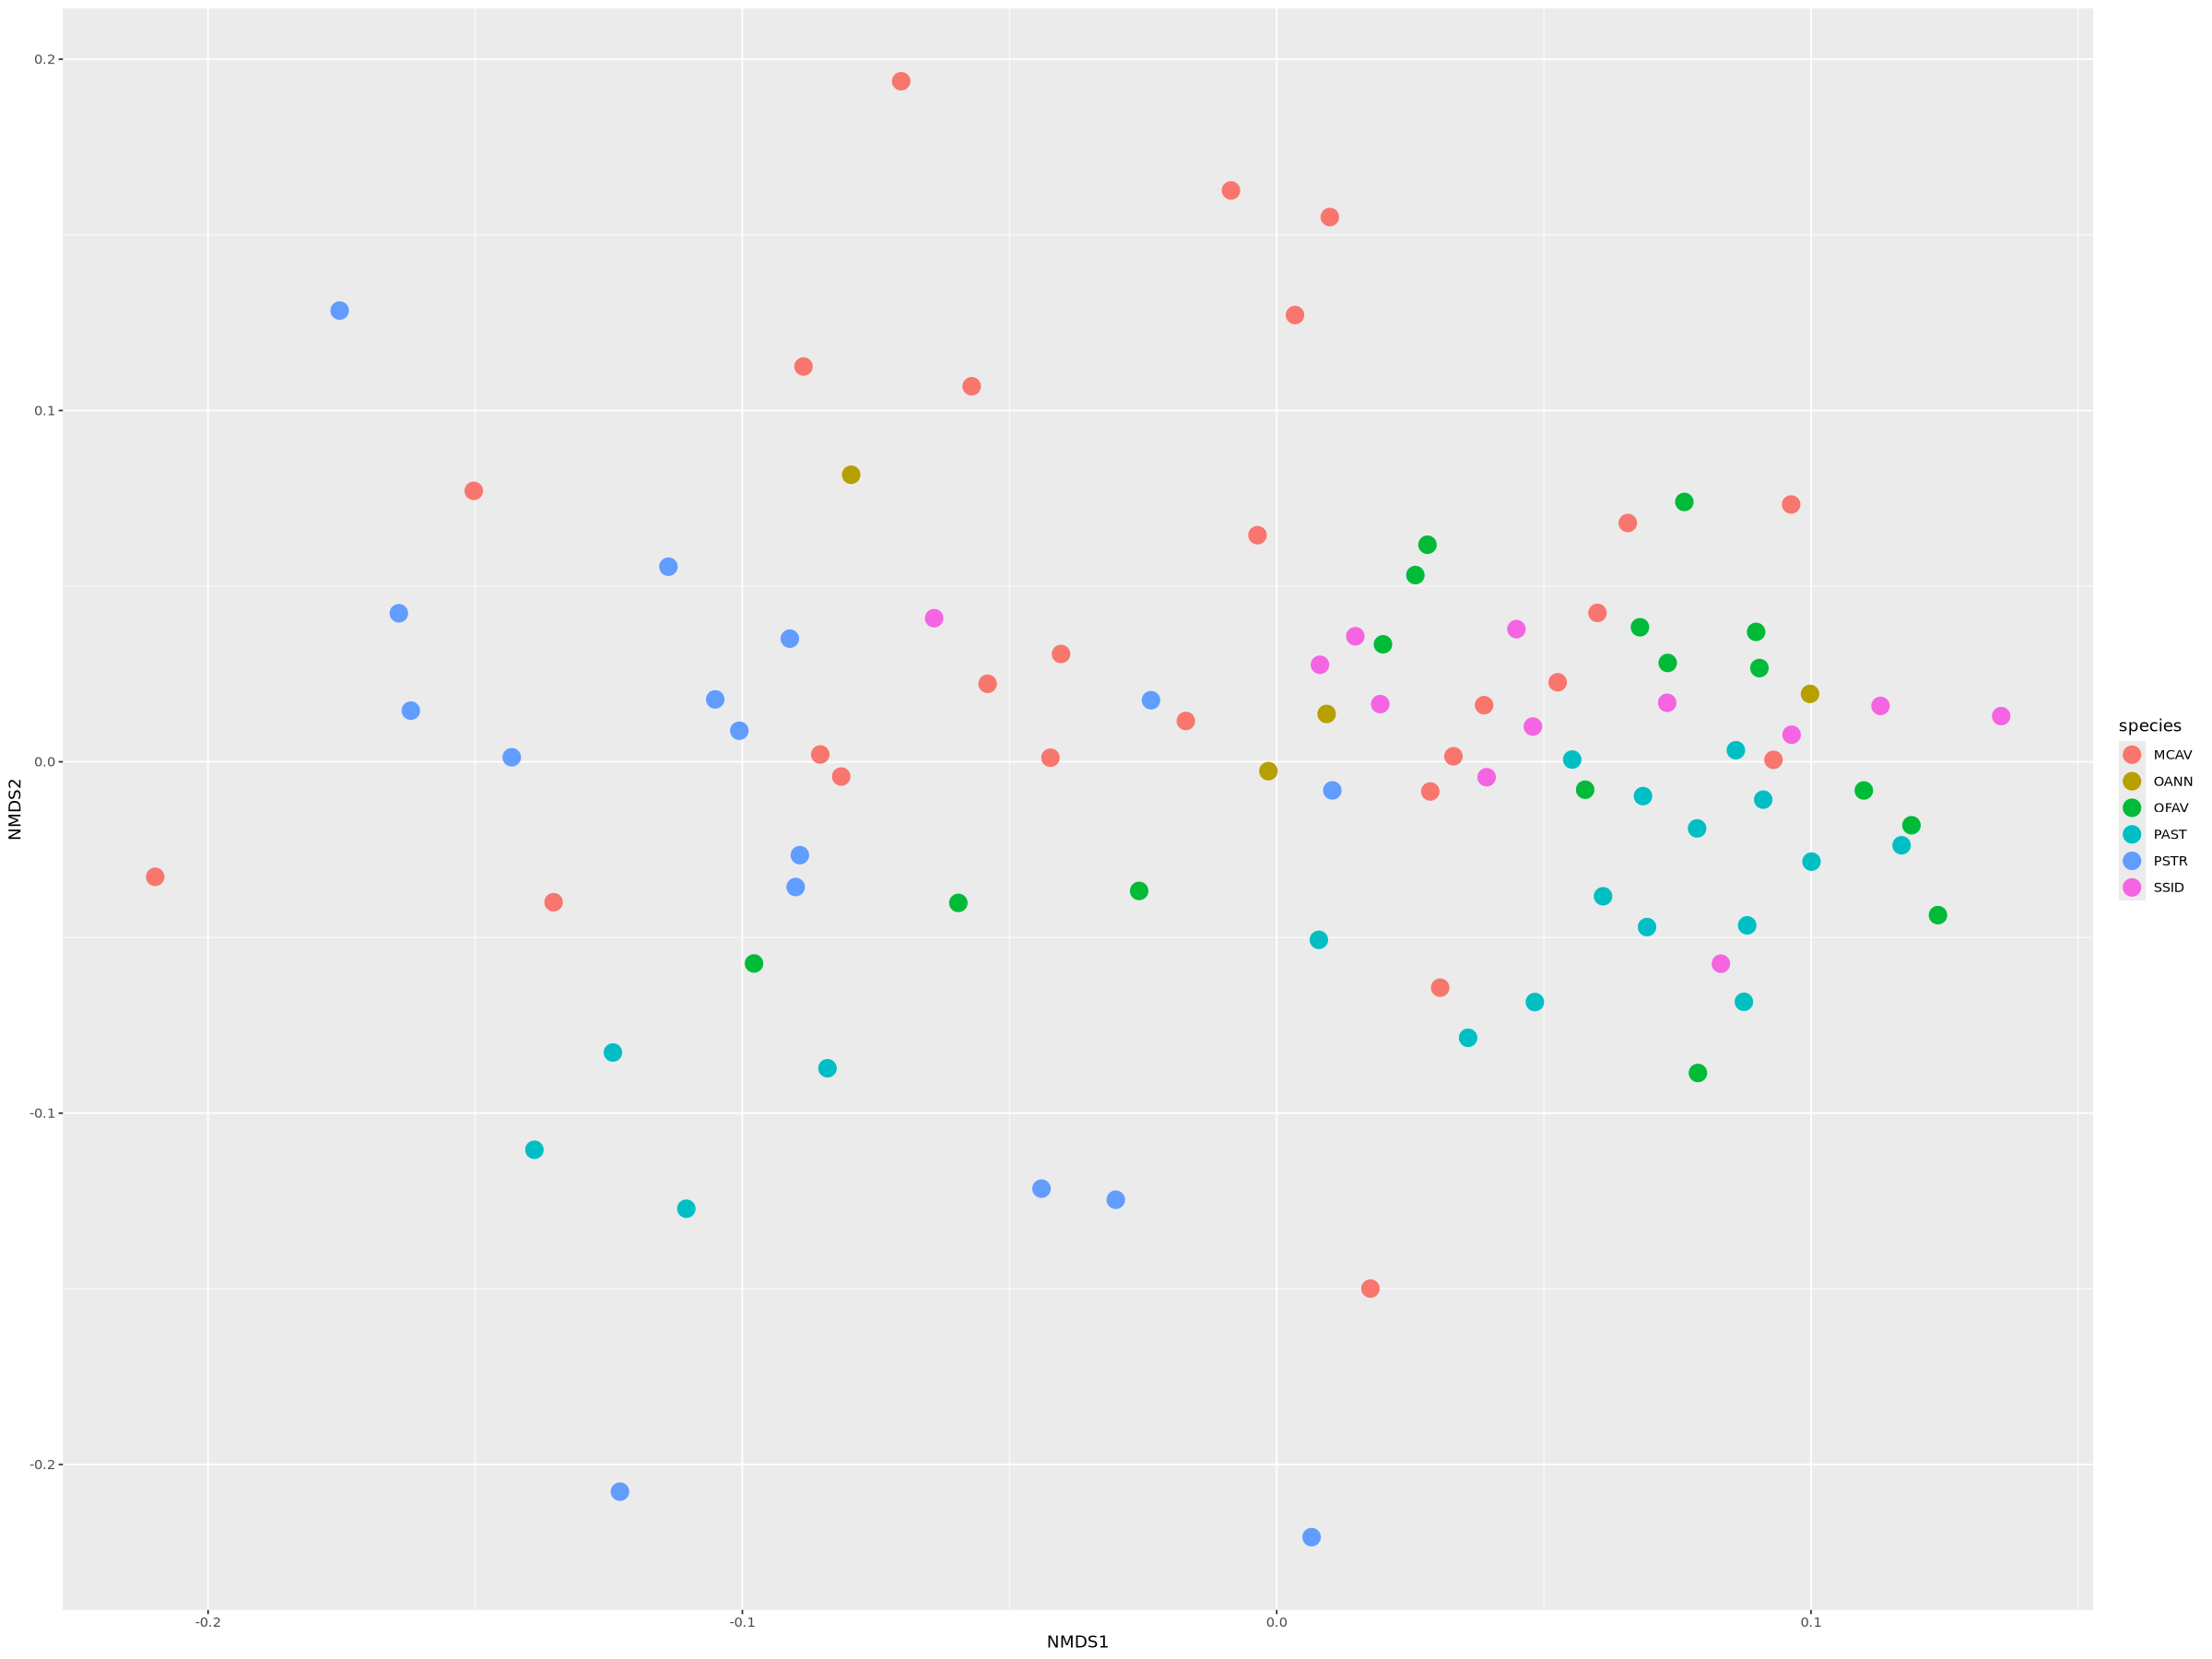

In [43]:
ps_norm.ord <- ordinate(ps_norm, "NMDS", "bray", trymax=1000)
plot_ordination(ps_norm, ps_norm.ord, type="samples", color="species")+ 
geom_point(size=5)

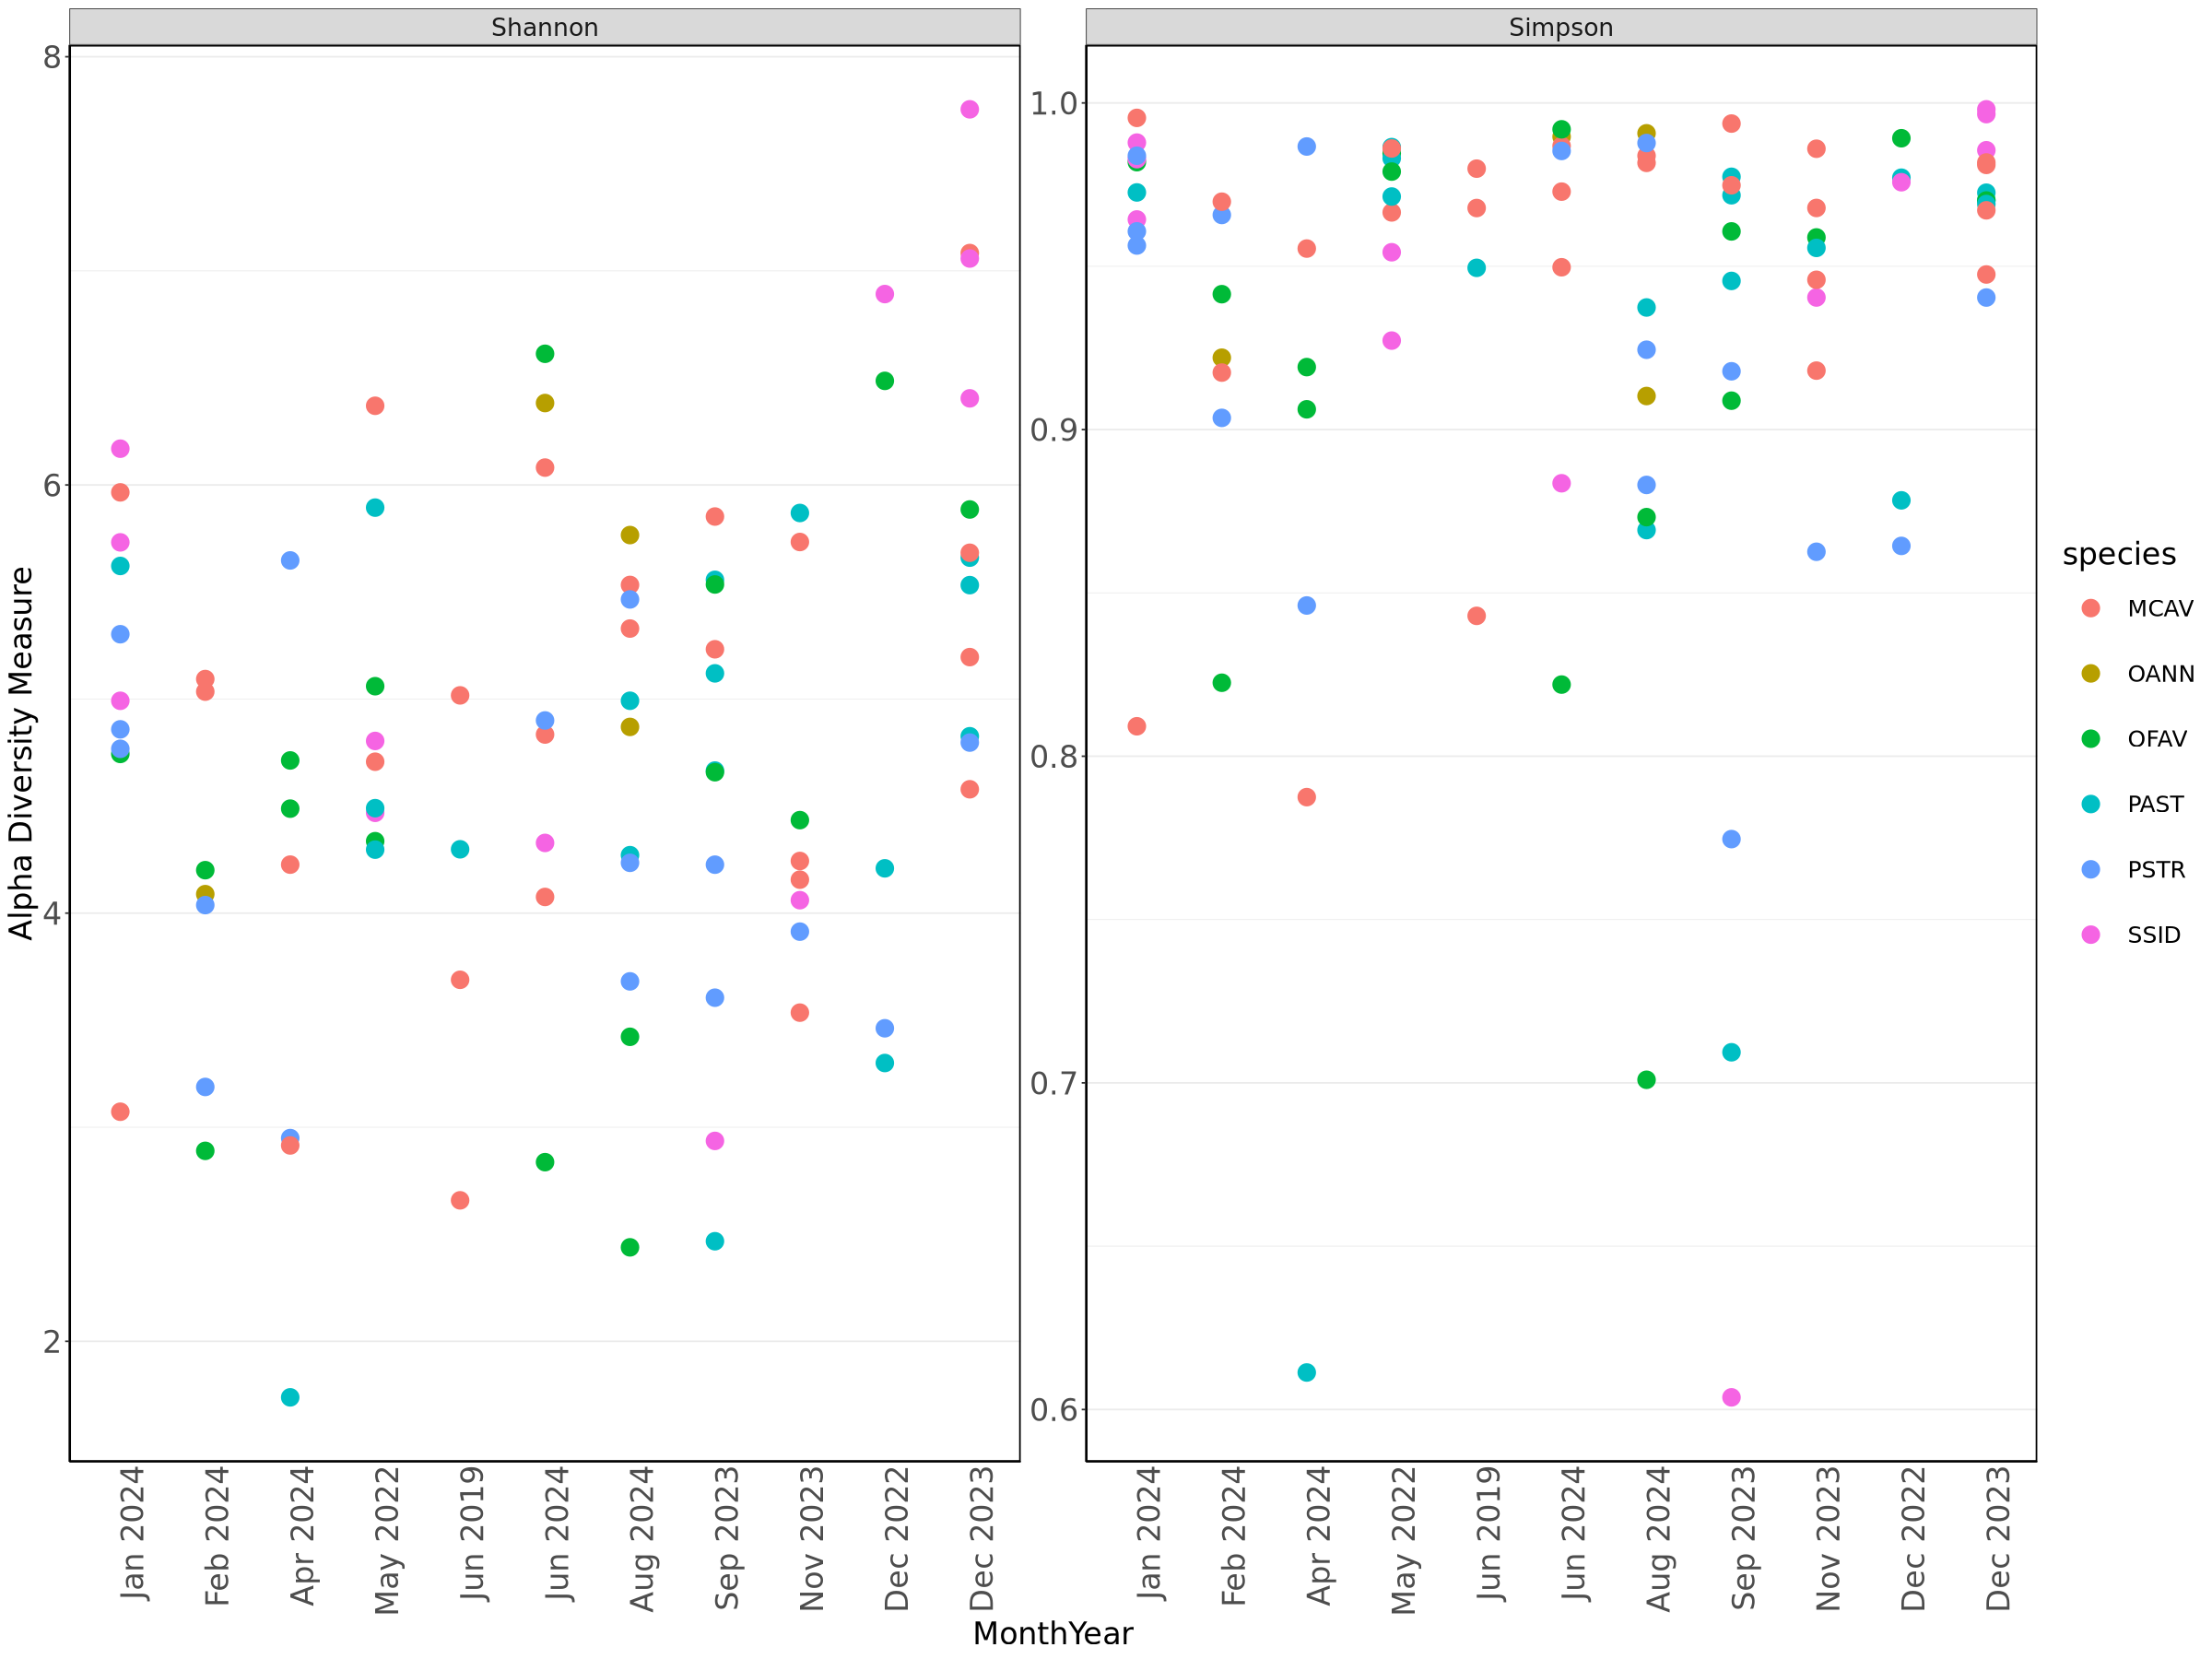

In [47]:
plot_richness(ps, x="MonthYear", measures=c("Shannon", "Simpson"), color="species") + 
geom_point(size=5) +
theme_bw() +
  theme(
    legend.position = "right",
      legend.title = element_text(size = 20),
  legend.text = element_text(size = 15),
  legend.key.width = unit(1.3, "cm"),     # make the legend keys wider
  legend.key.height = unit(1.5, "cm"),   # make them taller
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.line = element_line(color = "black"),
    axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1, size=20),
    axis.text.y = element_text(size = 20),
    text = element_text(size = 20)
  )

In [ ]:
plot_richness(ps, measures=c("Shannon", "Simpson"), color="species", shape="transect")